<a href="https://colab.research.google.com/github/markobrnovic/ML2024/blob/main/ML_Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1 a)**
This data set contains no labels. When using an FFNN to classify Ising phases we were gien a label dataset y_L30.txt and the model was learning by comparing the outcome of the FFNN to the labels. Here, we are reducing the dimensionality of the dataset using PCA and t-SNE to be able to group the dataset into two clusters. The clusters, unlike in FFNN, do not have labels but specifying which phase they belong to should be simple in post-processing.

In [2]:
#Uncomment to download data

# !wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/PCA_tutorial_data/Tutorial_Data.zip
# !unzip -j Tutorial_Data.zip
# !rm Tutorial_Data.zip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

In [33]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = max(sum(P), 1e-13)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if not np.issubdtype(X.dtype, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

**b)**

As we can see, the tsne takes as input an NxD array and reduces its dimensionality to some desired number first with PCA. So $X$ is a general NxD array. $\texttt{no_dims}$ is the number of desired dimensions in the final clustering analysis, and the data will be plotted on a 2D grid according to these two dimensions. $\texttt{initial_dims}$ is the number of dimensions remaining after PCA reduction. Perplexity is a hyperparameter specified by the user. It can be defined as

$$\mathrm{perp}(P_i) = 2^{H(P_i)},$$ where
$$ H(P_i) = -\sum_{j}p_{j|i}\log_2 p_{j|i},$$

the Shannon entropy of $P(i)$. We can think about it as an effective number of neighbours [2]. Although typically values for it range between 5 and 50, the algorithm is fairly robust to changes in perplexity.

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.736217
Iteration 20: error is 21.245624
Iteration 30: error is 17.899490
Iteration 40: error is 16.691417
Iteration 50: error is 16.343449
Iteration 60: error is 16.196554
Iteration 70: error is 16.109294
Iteration 80: error is 16.032129
Iteration 90: error is 15.980514
Iteration 100: error is 15.943617
Iteration 110: error is 2.333255
Iteration 120: error is 2.105986
Iteration 130: error is 1.919660
Iteration 140: error is 1.775132
Iteration 150: error is 1.663630
Iteration 160: error is 1.576106
Iteration 170: error is 1.506570
It

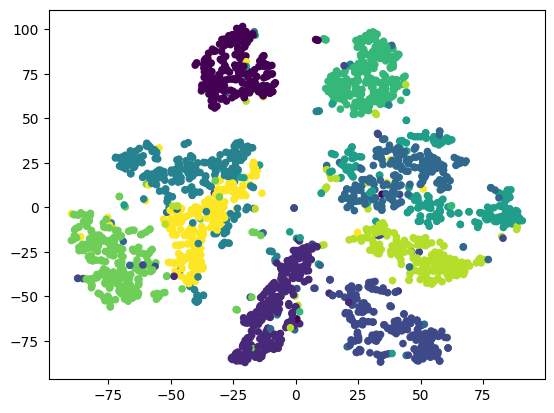

In [6]:
#demonstration of tsne on mnist data
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = np.loadtxt("mnist2500_X.txt")
    labels = np.loadtxt("mnist2500_labels.txt")
    Y = tsne(X, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [56]:
spins_ising_20 = np.loadtxt('spinConfigs_Ising_L20.txt')
spins_ising_40 = np.loadtxt('spinConfigs_Ising_L40.txt')
spins_ising_80 = np.loadtxt('spinConfigs_Ising_L80.txt')

temperatures_ising_20 = np.loadtxt('temperatures_Ising_L20.txt')
temperatures_ising_40 = np.loadtxt('temperatures_Ising_L40.txt')
temperatures_ising_80 = np.loadtxt('temperatures_Ising_L80.txt')

spins_gauge_20 = np.loadtxt('spinConfigs_gaugeTheory_L20.txt')
spins_gauge_40 = np.loadtxt('spinConfigs_gaugeTheory_L40.txt')
spins_gauge_80 = np.loadtxt('spinConfigs_gaugeTheory_L80.txt')

labels_gauge_20 = np.loadtxt('labels_gaugeTheory_L20.txt')
labels_gauge_40 = np.loadtxt('labels_gaugeTheory_L40.txt')
labels_gauge_80 = np.loadtxt('labels_gaugeTheory_L80.txt')

In [34]:
spins_ising_20_tsne = tsne(spins_ising_20, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.748357
Iteration 10: error is 20.440951
Iteration 20: error is 17.846941
Iteration 30: error is 16.988719
Iteration 40: error is 17.015041
Iteration 50: error is 17.030720
Iteration 60: error is 17.022530
Iteration 70: error is 17.017093
Iteration 80: error is 17.016246
Iteration 90: error is 17.015982
Iteration 100: error is 17.016132
Iteration 110: error is 2.740654
Iteration 120: error is 2.450871
Iteration 130: error is 2.199888
Iteration 140: error is 2.072008
Iteration 150: error is 1.990570
Iteration 160: error is 1.929969
Iteration 170: error is 1.881804
Iteration 180: error is 1.841402
Iteration 190: error is 1.806444
Iteration 200: error is 1.776887
Iteration 210: error is 1.751427
Iteration 220: error is 1.728703

In [52]:
spins_ising_40_tsne = tsne(spins_ising_40, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.897560
Iteration 10: error is 21.044363
Iteration 20: error is 18.139972
Iteration 30: error is 17.370136
Iteration 40: error is 17.234440
Iteration 50: error is 17.215423
Iteration 60: error is 17.202068
Iteration 70: error is 17.194675
Iteration 80: error is 17.191853
Iteration 90: error is 17.187843
Iteration 100: error is 17.181643
Iteration 110: error is 2.661052
Iteration 120: error is 2.435129
Iteration 130: error is 2.310207
Iteration 140: error is 2.222491
Iteration 150: error is 2.153672
Iteration 160: error is 2.097394
Iteration 170: error is 2.050757
Iteration 180: error is 2.011843
Iteration 190: error is 1.979878
Iteration 200: error is 1.952920
Iteration 210: error is 1.930349
Iteration 220: error is 1.910892

In [54]:
spins_ising_80_tsne = tsne(spins_ising_80, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.548898
Iteration 10: error is 21.156202
Iteration 20: error is 18.035739
Iteration 30: error is 16.774979
Iteration 40: error is 16.539129
Iteration 50: error is 16.357880
Iteration 60: error is 16.359071
Iteration 70: error is 16.334014
Iteration 80: error is 16.307536
Iteration 90: error is 16.298692
Iteration 100: error is 16.275277
Iteration 110: error is 2.388273
Iteration 120: error is 2.222228
Iteration 130: error is 2.157931
Iteration 140: error is 2.113895
Iteration 150: error is 2.076640
Iteration 160: error is 2.042926
Iteration 170: error is 2.013910
Iteration 180: error is 1.989013
Iteration 190: error is 1.967359
Iteration 200: error is 1.948775
Iteration 210: error is 1.932699
Iteration 220: error is 1.918601

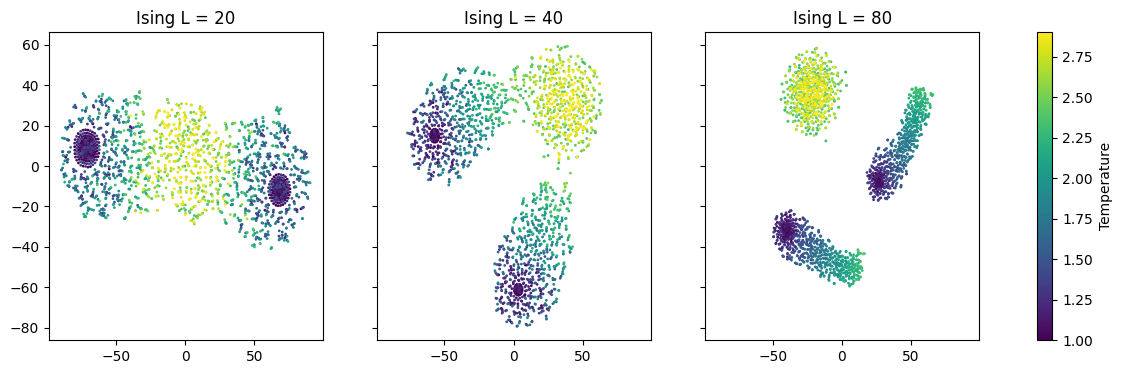

In [77]:
# Create a figure and three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex = True, sharey = True)

# Plot the scatter plots on each subplot
scatter0 = axs[0].scatter(spins_ising_20_tsne[:, 0], spins_ising_20_tsne[:, 1], c=temperatures_ising_20, s = 1)
axs[0].set_title('Ising L = 20')

scatter1 = axs[1].scatter(spins_ising_40_tsne[:, 0], spins_ising_40_tsne[:, 1], c=temperatures_ising_40, s = 1)
axs[1].set_title('Ising L = 40')

scatter2 = axs[2].scatter(spins_ising_80_tsne[:, 0], spins_ising_80_tsne[:, 1], c=temperatures_ising_80, s = 1)
axs[2].set_title('Ising L = 80')

# Add a colorbar on the right side of the last subplot
fig.colorbar(scatter2, ax=axs, orientation='vertical', label='Temperature')

**d)**

The clustering improves with the size of the lattice. This makes sense since the closer we get to an infinite lattice, the closer we get to actual definitions of paramagnetic/ferromagnetic phases.

Applying t-SNE on the Ising L = 80 again:

In [78]:
spins_ising_80_tsne_run2 = tsne(spins_ising_80, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.548898
Iteration 10: error is 21.282857
Iteration 20: error is 18.394859
Iteration 30: error is 16.591037
Iteration 40: error is 16.524283
Iteration 50: error is 16.392206
Iteration 60: error is 16.303760
Iteration 70: error is 16.326289
Iteration 80: error is 16.302959
Iteration 90: error is 16.282894
Iteration 100: error is 16.262004
Iteration 110: error is 2.407643
Iteration 120: error is 2.227189
Iteration 130: error is 2.150355
Iteration 140: error is 2.102104
Iteration 150: error is 2.063797
Iteration 160: error is 2.031567
Iteration 170: error is 2.003372
Iteration 180: error is 1.979286
Iteration 190: error is 1.958421
Iteration 200: error is 1.939954
Iteration 210: error is 1.924021
Iteration 220: error is 1.910132

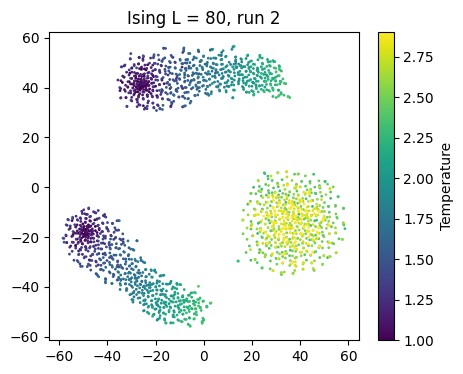

In [79]:
# Create a figure and three subplots arranged horizontally
fig, ax = plt.subplots(1, figsize=(5, 4))

# Plot the scatter plots on each subplot
scatter = ax.scatter(spins_ising_80_tsne_run2[:, 0], spins_ising_80_tsne_run2[:, 1], c=temperatures_ising_80, s = 1)
ax.set_title('Ising L = 80, run 2')

# Add a colorbar on the right side of the last subplot
fig.colorbar(scatter, ax=ax, orientation='vertical', label='Temperature')

*   Clearly the plot differs from the one in the figure above. Although there are three distinct clusters, they are in different positions and have slightly different shapes. The reason is that t-SNE (unlike PCA) has a non-convex cost function. As such, it must be minimised with an appropriate method, and here gradient descent is used. The initial 2D array is initialised randomly, which can be seen from a line in the $\texttt{tsne}$ function: $\texttt{Y = np.random.randn(n, no_dims)}$. Starting from random initial condition also implies a random clustering procedure.
*   Indeed our results are similar to Figure 6 in Juan and Roger's paper. The three clusters are separated and correspond to phases of the 2D Ising.
* To see the differences between PCA and t-SNE, first consider the type of data we are working with. We have $L^2$ vectors of length 2000 and what we want to do is find the 'most important' directions in this space with $L^2$ dimensions. This amounts to finding the axis corresponding to some linear combinations of the axes specified by the unit vectors. PCA is very useful for the Ising model because the order parameter is indeed a linear combination of the vectors (spins) and is called the magnetisation: $M = \frac{1}{N}\sum_{i =1}^{N}s_i$. This is also the first principal component obtained from PCA. Although we have no clustering, when we plot these points on say a domain spanned by the first two principal components and label each point with a corresponding temperature. We can see the two nodes corresponding to two FM phases at low temperatures, and everything in between is some higher temperature PM states. What we can also see is that with increasing lattice size, we can get close to truly clustering FM and PM phases (in that sense PCA and t-SNE are similar). So PCA is useful for this specific example because the order parameter is a linear combination of the 'state' vectors. t-SNE on the other hand, first uses PCA to pre-process the data and reduce the dimensionality of the problem, and then further reduces the dimensionality while not assuming that the most important dimension is a linear combination of the existing ones. Therefore, the axes we get in the end for plotting bear little to no physical meaning, but the separation between the clusters is much more apparent. In conclusion, we lose physical significance of the most important dimensions, but we get a clearer picture of how many phases there are.

**e)**

In [81]:
spins_gauge_20_tsne = tsne(spins_gauge_20, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 3.422550
Iteration 10: error is 20.600566
Iteration 20: error is 20.689538
Iteration 30: error is 21.362283
Iteration 40: error is 21.498339
Iteration 50: error is 21.395667
Iteration 60: error is 21.488389
Iteration 70: error is 21.523305
Iteration 80: error is 21.251212
Iteration 90: error is 21.142973
Iteration 100: error is 21.364989
Iteration 110: error is 3.818860
Iteration 120: error is 3.347495
Iteration 130: error is 3.110203
Iteration 140: error is 3.014809
Iteration 150: error is 2.950017
Iteration 160: error is 2.900456
Iteration 170: error is 2.858229
Iteration 180: error is 2.825282
Iteration 190: error is 2.796980
Iteration 200: error is 2.773444
Iteration 210: error is 2.752543
Iteration 220: error is 2.735991
Iteration 230: error is 2.722344
Iteration 240: error is 2.710385
Iteration 250: error is

In [82]:
spins_gauge_40_tsne = tsne(spins_gauge_40, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 5.169702
Iteration 10: error is 20.576675
Iteration 20: error is 20.280392
Iteration 30: error is 20.441234
Iteration 40: error is 21.014947
Iteration 50: error is 21.234370
Iteration 60: error is 20.958456
Iteration 70: error is 21.175196
Iteration 80: error is 20.841649
Iteration 90: error is 21.456829
Iteration 100: error is 21.817371
Iteration 110: error is 3.806462
Iteration 120: error is 3.441506
Iteration 130: error is 3.245236
Iteration 140: error is 3.142727
Iteration 150: error is 3.069314
Iteration 160: error is 3.002942
Iteration 170: error is 2.916005
Iteration 180: error is 2.865187
Iteration 190: error is 2.813638
Iteration 200: error is 2.752302
Iteration 210: error is 2.725776
Iteration 220: error is 2.713409
Iteration 230: error is 2.702773
Iteration 240: error is 2.693283
Iteration 250: error is

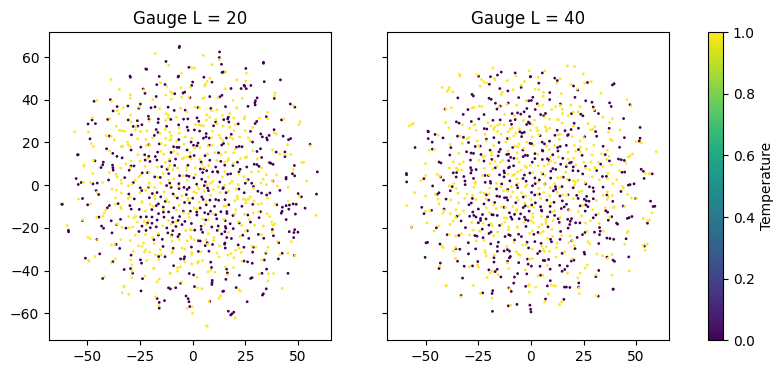

In [86]:
# Create a figure and three subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex = True, sharey = True)

# Plot the scatter plots on each subplot
scatter0 = axs[0].scatter(spins_gauge_20_tsne[:, 0], spins_gauge_20_tsne[:, 1], c=labels_gauge_20, s = 1)
axs[0].set_title('Gauge L = 20')

scatter1 = axs[1].scatter(spins_gauge_40_tsne[:, 0], spins_gauge_40_tsne[:, 1], c=labels_gauge_40, s = 1)
axs[1].set_title('Gauge L = 40')

# Add a colorbar on the right side of the last subplot
fig.colorbar(scatter1, ax=axs, orientation='vertical', label='Temperature')

**f)**

As can be seen above, t-SNE fails to cluster phases of the 2D classical Ising gauge field. The reason is that we can have two topologically equivalent configurations in the gauge theory, one differing from the other by a Wilson loop. Differing by a Wilson loop implies that the number of spins that are different between the two are of the order of $L$, so their Euclidean distance would be large and would not be preferred, even though they belong to the same topological phase. In conclusion, the reason is that in regular Ising model, the order parameter that we use to classify the phase (magnetisation), or rather the difference in magnetisation between two configurations, is correlated with the Euclidean distance of the spins of the two configurations. Here the order parameter is not local but global and characterised by these loops. It is therefore uncorrelated to the Euclidean distance between two configurations, and there is no reason why t-SNE should be able to cluster them.